In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
data = pd.read_csv('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/Obfuscated-MalMem2022-v3.csv')
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
#data['class']=lab.fit_transform(data['Class'])
#data['category']=lab.fit_transform(data['Category'])
#data['family']=lab.fit_transform(data['Family'])
#data = data.drop(['Class'], axis=1)
#data = data.drop(['Category'], axis=1)
#data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [4]:
data = data.drop_duplicates()

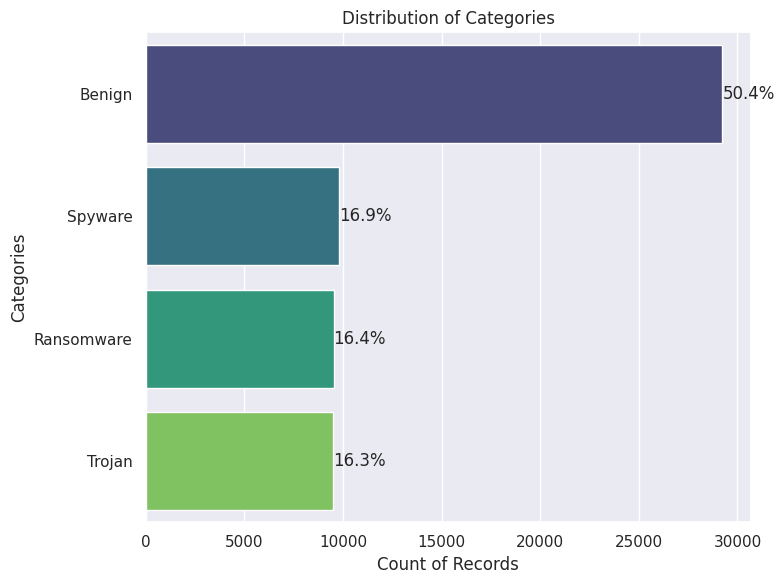

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Family' is the name of the column containing the 16 unique values
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Category', data=data, palette='viridis', order=data['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Count of Records')
plt.ylabel('Categories')

# Calculate percentages and annotate the bars
total_records = len(data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total_records)
    x = p.get_width() + 1
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='left', va='center')

plt.tight_layout()
plt.show()


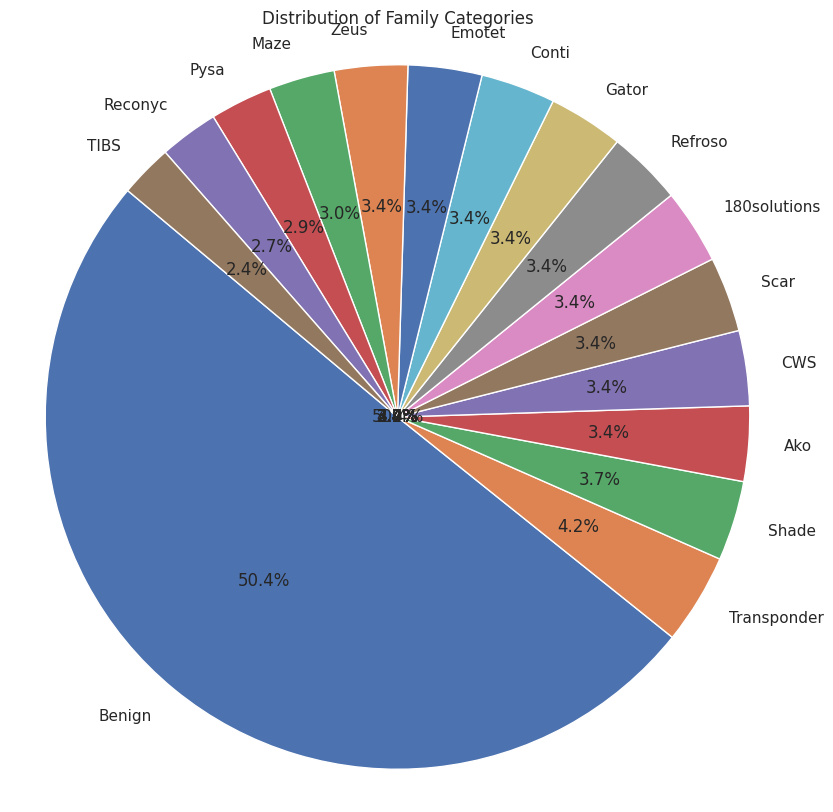

In [30]:
import matplotlib.pyplot as plt

# Calculate counts for each family category
family_counts = data['Family'].value_counts()
labels = family_counts.index
sizes = family_counts.values

plt.figure(figsize=(10, 10))  # Adjust the figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Family Categories')
plt.axis('equal')

# Add percentage labels inside the pie chart
total = sum(sizes)
for i, (label, size) in enumerate(zip(labels, sizes)):
    percentage = '{:.1f}%'.format(100 * size / total)
    angle = (sizes[i] / total) * 360
    if angle > 5:  # Show percentage only if the slice is larger than 5%
        plt.text(0, 0, percentage, ha='center', va='center')

plt.show()


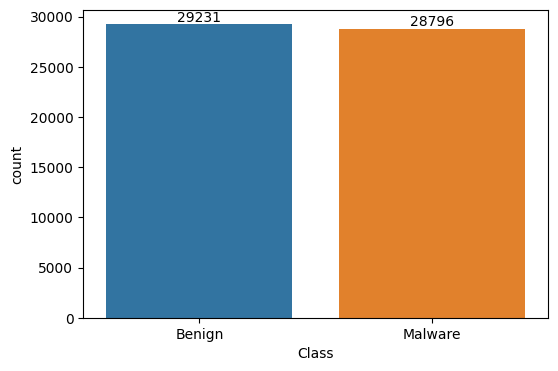

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='class',data=data)
for i in ax.containers:
    ax.bar_label(i,)

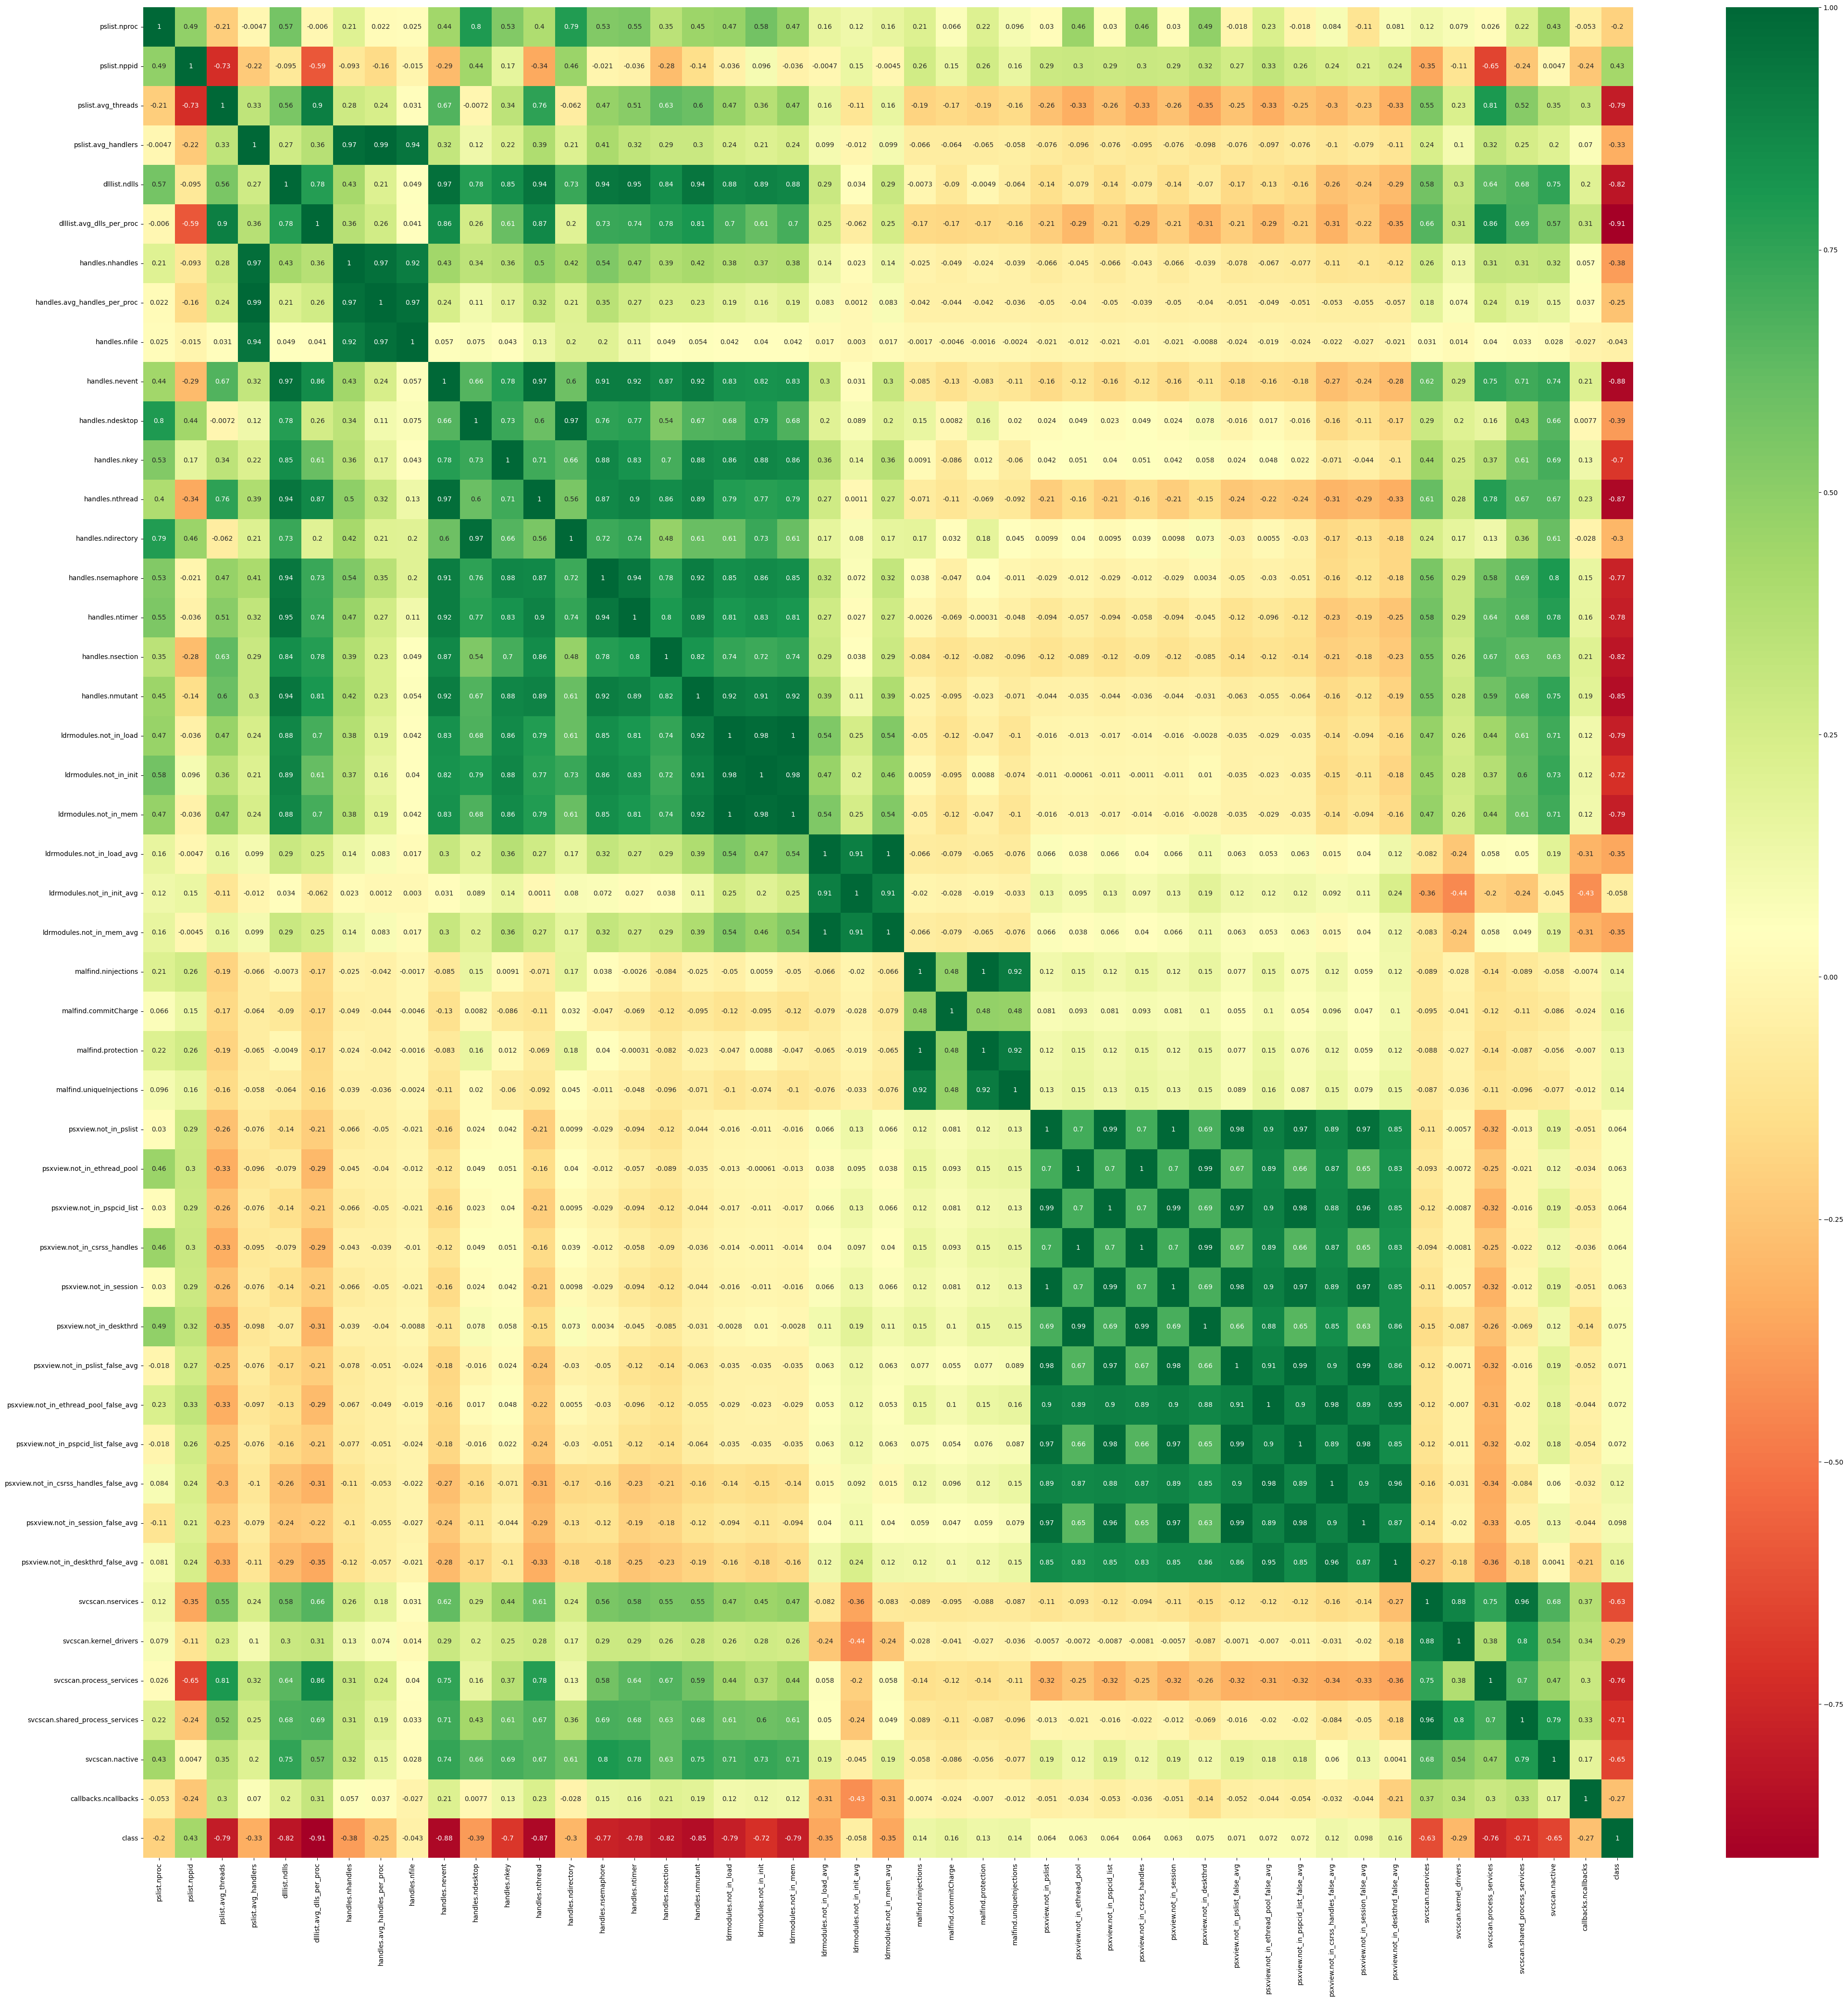

In [ ]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# Assuming your dataset is stored in a pandas DataFrame called 'df'

# Identify skewed features
skewness = data.apply(lambda x: skew(x))
skew_features = skewness[abs(skewness) > 0.5].index

# Apply log transformation to skewed features
#data[skew_features] = np.log1p(data[skew_features])

# Alternatively, you can use PowerTransformer for a more general approach
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data[skew_features] = scaler.fit_transform(data[skew_features].values)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


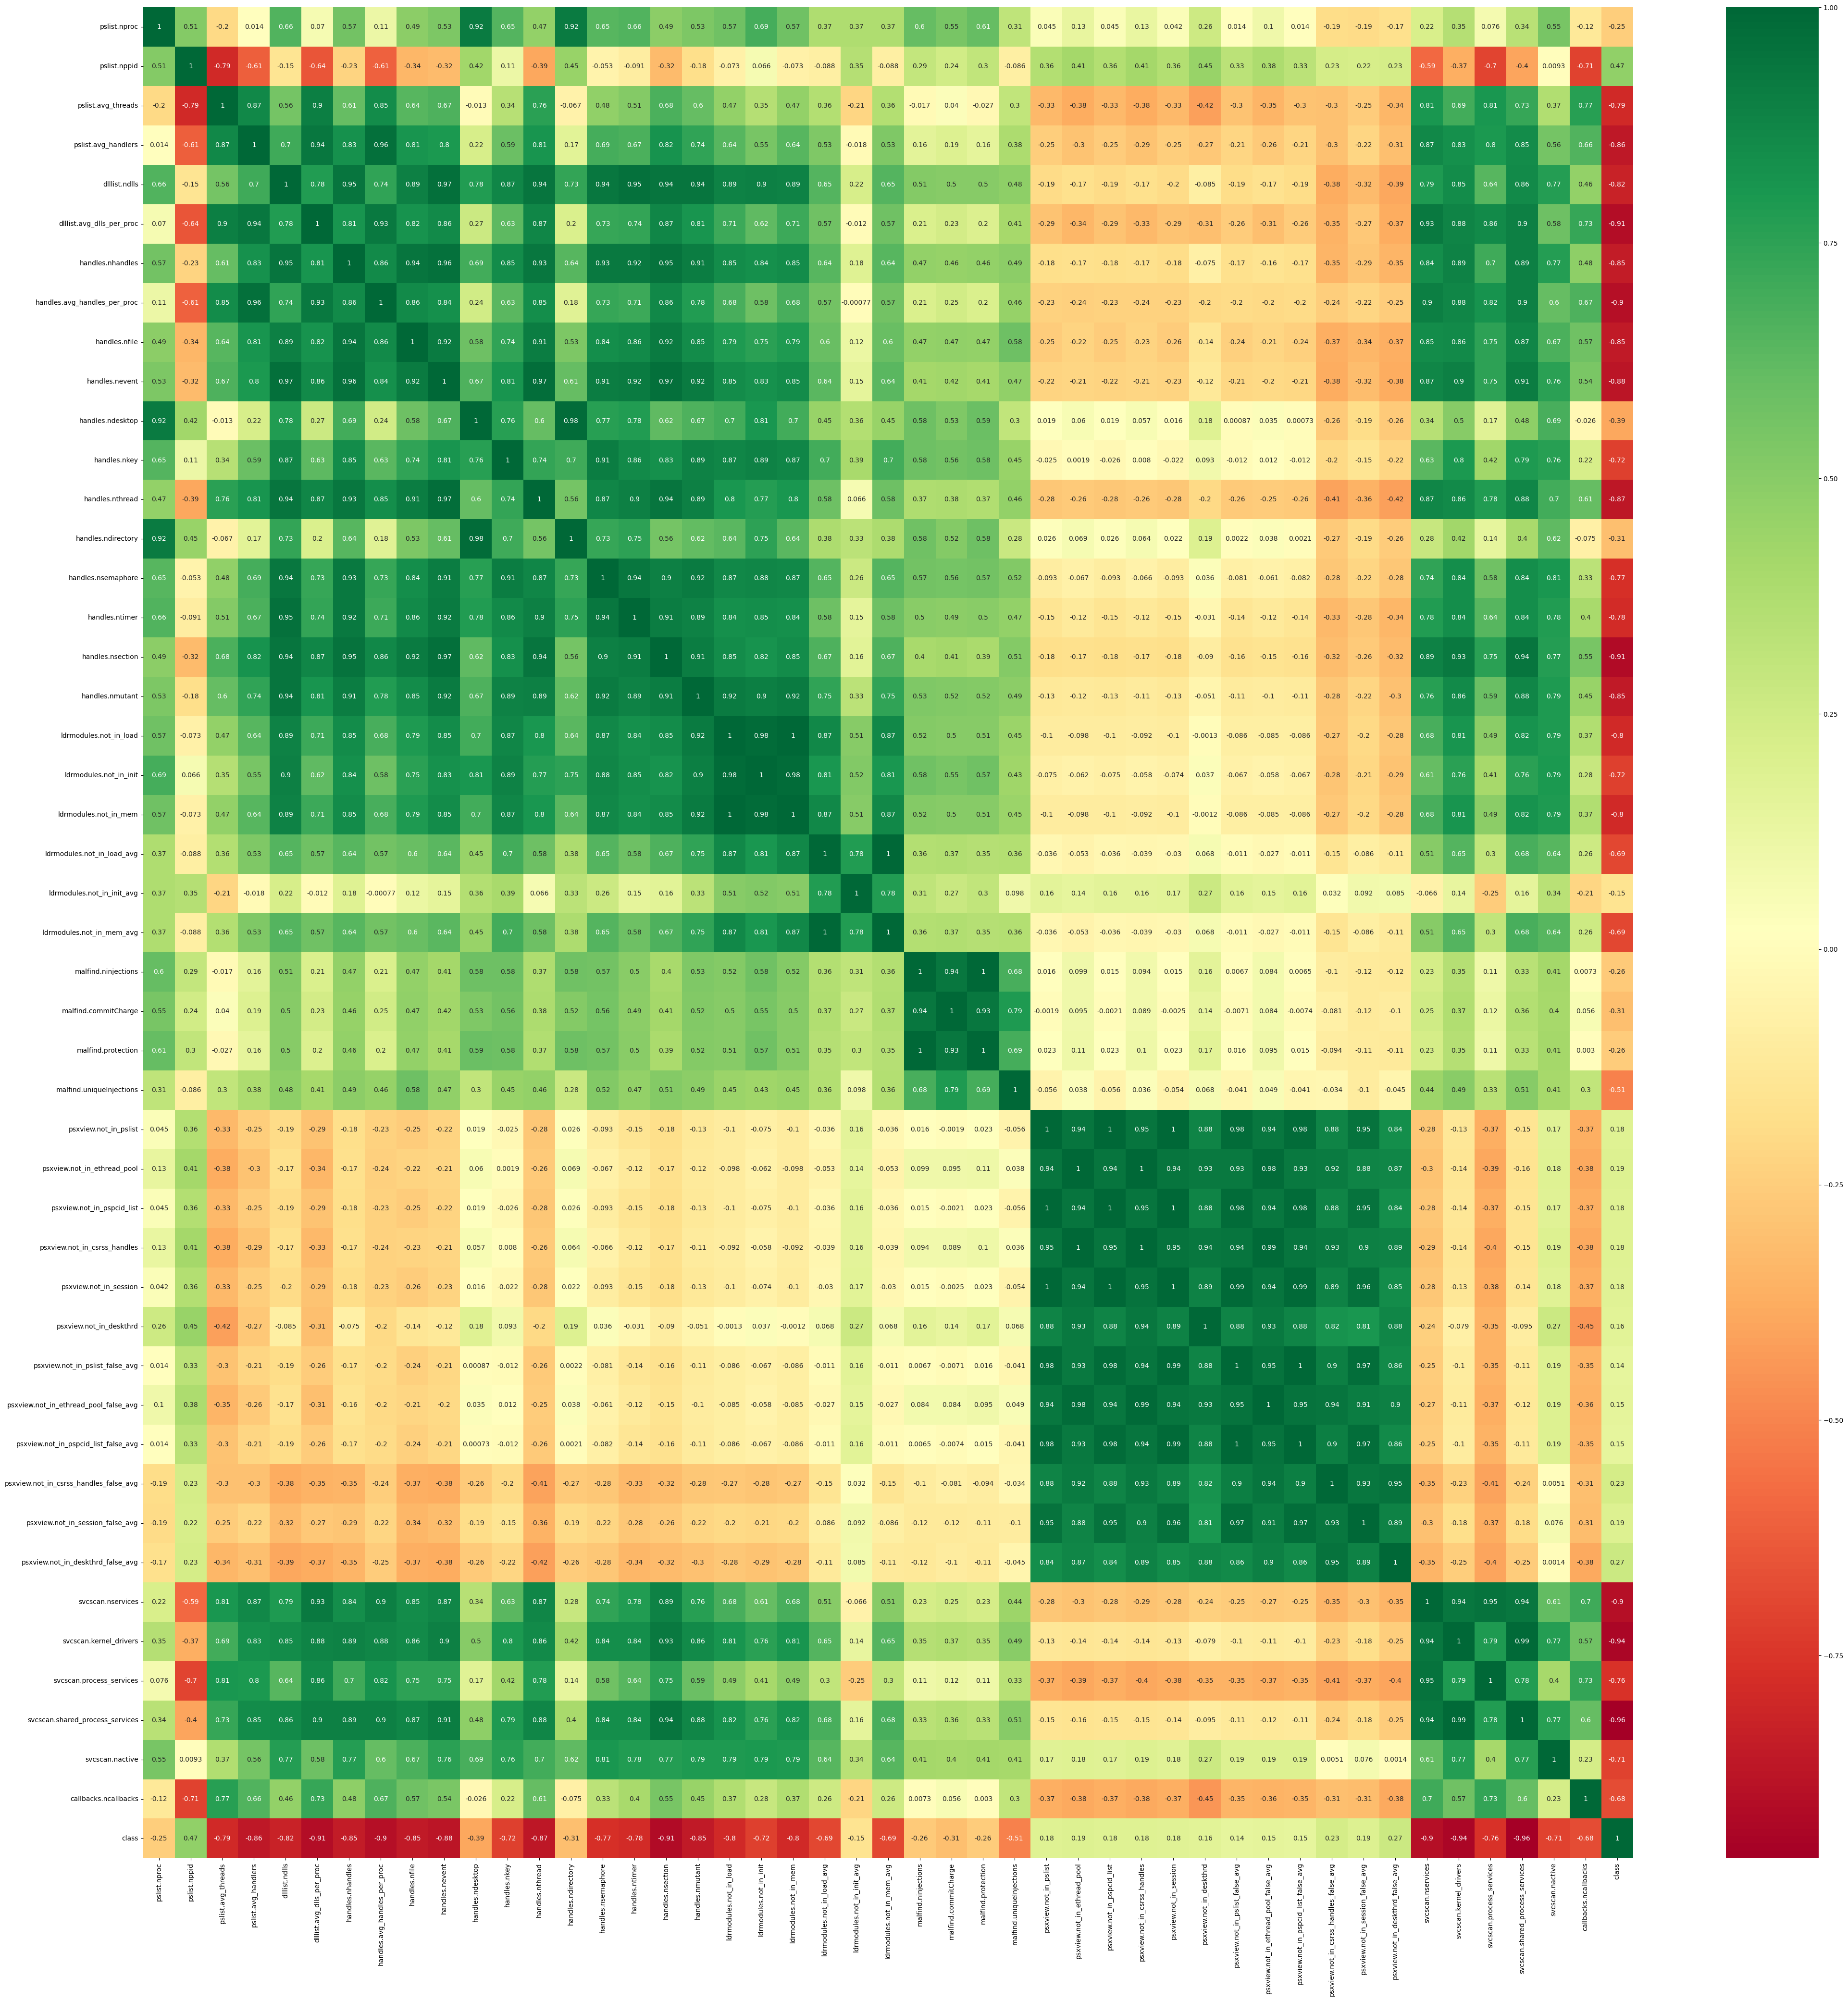

In [ ]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(50,50))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
labels=["Benign","Malware"]

fraud_or_not = data["class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=data['class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["green","black"]
             ,title="Benign (Green) , Malware (black)")
fig.show()

In [ ]:
data.describe()

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
count  58027.000000  58027.000000        58027.000000         58027.000000   
mean      41.408724     14.709066           11.351106           247.824527   
std        5.778362      2.661443            1.587769           112.315505   
min       21.000000      8.000000            1.650000            34.962500   
25%       40.000000     12.000000            9.973684           208.777778   
50%       41.000000     15.000000           11.023256           244.839466   
75%       43.000000     16.000000           12.868096           290.100683   
max      240.000000     72.000000           16.818182         24845.951220   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
count   58027.000000               58027.000000      5.802700e+04   
mean     1813.122788                  43.747832      1.027534e+04   
std       329.867572                   5.738898      4.885798e+03   
min       670.000000                   7.333333      3.514000e+03   
25%      1556.000000                  38.850000      8.403000e+03   
50%      1740.000000                  42.995820      9.452000e+03   
75%      2088.000000                  49.625000      1.219700e+04   
max      3443.000000                  53.170732      1.047310e+06   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  ...  \
count                  58027.000000   58027.000000    58027.000000  ...   
mean                     249.876725     901.221035     3578.270805  ...   
std                      146.650911    3449.046120      805.521550  ...   
min                       71.139241     266.000000      966.000000  ...   
25%                      209.761905     646.000000     2923.000000  ...   
50%                      248.443291     840.000000     3179.000000  ...   
75%                      291.445352    1081.000000     4329.000000  ...   
max                    33784.193550  807008.000000     7892.000000  ...   

       psxview.not_in_csrss_handles_false_avg  \
count                            58027.000000   
mean                                 0.141661   
std                                  0.061363   
min                                  0.025806   
25%                                  0.100000   
50%                                  0.119048   
75%                                  0.164771   
max                                  0.854167   

       psxview.not_in_session_false_avg  psxview.not_in_deskthrd_false_avg  \
count                      58027.000000                       58027.000000   
mean                           0.087878                           0.187567   
std                            0.055043                           0.061477   
min                            0.008333                           0.043750   
25%                            0.048780                           0.146341   
50%                            0.066667                           0.166089   
75%                            0.113636                           0.210526   
max                            0.576923                           0.862500   

       svcscan.nservices  svcscan.kernel_drivers  svcscan.process_services  \
count       58027.000000            58027.000000              58027.000000   
mean          391.368501              221.410361                 25.072070   
std             4.539732                1.999856                  1.531202   
min            94.000000               55.000000                  7.000000   
25%           389.000000              221.000000                 24.000000   
50%           392.000000              222.000000                 24.000000   
75%           395.000000              222.000000                 27.000000   
max           395.000000              222.000000                 27.000000   

       svcscan.shared_process_services  svcscan.nactive  callbacks.ncallbacks  \
count                     58027.000000     58027.000000          58027.000000

<h3>Normalization</h3>

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [ ]:
data.describe()

pslist.nproc  pslist.nppid  pslist.avg_threads  pslist.avg_handlers  \
count  5.802700e+04  5.802700e+04        5.802700e+04         5.802700e+04   
mean   4.506173e-16  9.796029e-19        3.546163e-16        -1.689815e-16   
std    1.000009e+00  1.000009e+00        1.000009e+00         1.000009e+00   
min   -3.531952e+00 -2.520859e+00       -6.109952e+00        -1.895231e+00   
25%   -2.437950e-01 -1.017902e+00       -8.675282e-01        -3.476553e-01   
50%   -7.073407e-02  1.093151e-01       -2.064869e-01        -2.657769e-02   
75%    2.753878e-01  4.850543e-01        9.554303e-01         3.764086e-01   
max    3.436839e+01  2.152645e+01        3.443274e+00         2.190111e+02   

       dlllist.ndlls  dlllist.avg_dlls_per_proc  handles.nhandles  \
count   5.802700e+04               5.802700e+04      5.802700e+04   
mean   -2.938809e-16              -1.073645e-15     -2.096350e-16   
std     1.000009e+00               1.000009e+00      1.000009e+00   
min    -3.465429e+00              -6.345262e+00     -1.383888e+00   
25%    -7.794795e-01              -8.534520e-01     -3.832235e-01   
50%    -2.216751e-01              -1.310388e-01     -1.685177e-01   
75%     8.333028e-01               1.024102e+00      3.933196e-01   
max     4.941047e+00               1.641950e+00      2.122568e+02   

       handles.avg_handles_per_proc  handles.nfile  handles.nevent  ...  \
count                  5.802700e+04   5.802700e+04    5.802700e+04  ...   
mean                   2.987789e-17   1.622467e-17    8.620506e-17  ...   
std                    1.000009e+00   1.000009e+00    1.000009e+00  ...   
min                   -1.218806e+00  -1.841745e-01   -3.242984e+00  ...   
25%                   -2.735419e-01  -7.399821e-02   -8.134810e-01  ...   
50%                   -9.774547e-03  -1.775029e-02   -4.956717e-01  ...   
75%                    2.834554e-01   5.212471e-02    9.319871e-01  ...   
max                    2.286696e+02   2.337208e+02    5.355246e+00  ...   

       psxview.not_in_csrss_handles_false_avg  \
count                            5.802700e+04   
mean                             1.209810e-16   
std                              1.000009e+00   
min                             -1.888046e+00   
25%                             -6.789386e-01   
50%                             -3.685259e-01   
75%                              3.766156e-01   
max                              1.161146e+01   

       psxview.not_in_session_false_avg  psxview.not_in_deskthrd_false_avg  \
count                      5.802700e+04                       5.802700e+04   
mean                      -2.248189e-16                       2.036350e-16   
std                        1.000009e+00                       1.000009e+00   
min                       -1.445132e+00                      -2.339392e+00   
25%                       -7.103026e-01                      -6.705940e-01   
50%                       -3.853527e-01                      -3.493676e-01   
75%                        4.679765e-01                       3.734649e-01   
max                        8.884809e+00                       1.097875e+01   

       svcscan.nservices  svcscan.kernel_drivers  svcscan.process_services  \
count       5.802700e+04            5.802700e+04              5.802700e+04   
mean       -5.720881e-15            4.179966e-15              3.526571e-16   
std         1.000009e+00            1.000009e+00              1.000009e+00   
min        -6.550411e+01           -8.321190e+01             -1.180264e+01   
25%        -5.217316e-01           -2.051969e-01             -7.001552e-01   
50%         1.391061e-01            2.948435e-01             -7.001552e-01   
75%         7.999438e-01            2.948435e-01              1.259107e+00   
max         7.999438e-01            2.948435e-01              1.259107e+00   

       svcscan.shared_process_services  svcscan.nactive  callbacks.ncallbacks  \
count                     5.802700e+04     5.802700e+04          5.802700e+04

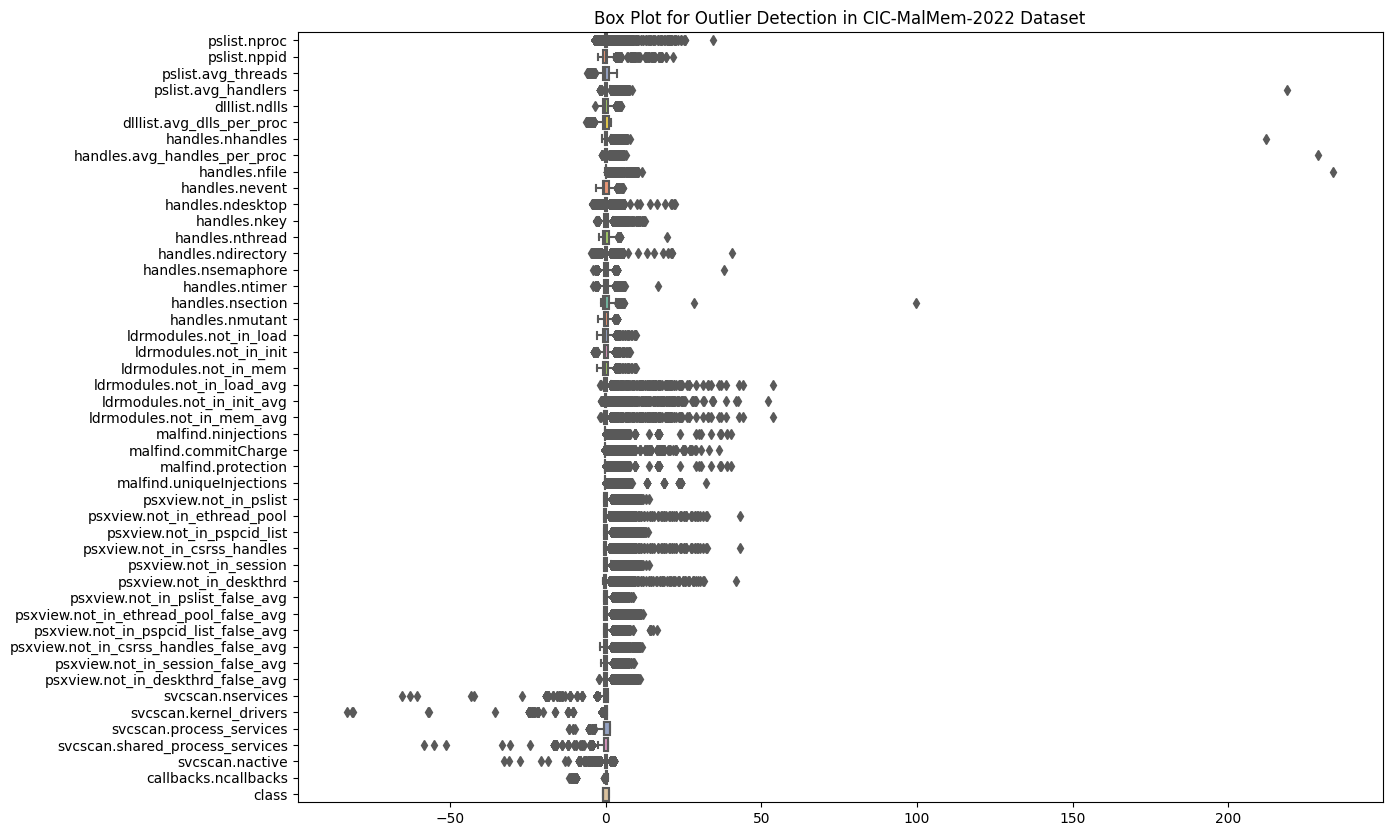

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# Drop non-numeric columns if necessary
numeric_df = data.select_dtypes(include=[np.number])

# Create a box plot for each feature
plt.figure(figsize=(14, 10))
sns.boxplot(data=numeric_df, orient='h', palette='Set2')
plt.title('Box Plot for Outlier Detection in CIC-MalMem-2022 Dataset')
plt.show()

In [ ]:
import pandas as pd
from scipy import stats

# Define a threshold for z-score, typically 2 or 3
z_score_threshold = 3

# Function to remove outliers based on z-score for all columns
def remove_outliers_zscore_all_columns(data, threshold):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outliers = (abs_z_scores > threshold).all(axis=1)
    df_no_outliers = data[~outliers]
    return df_no_outliers

# Apply z-score outlier removal for all columns
df_no_outliers = remove_outliers_zscore_all_columns(data, z_score_threshold)

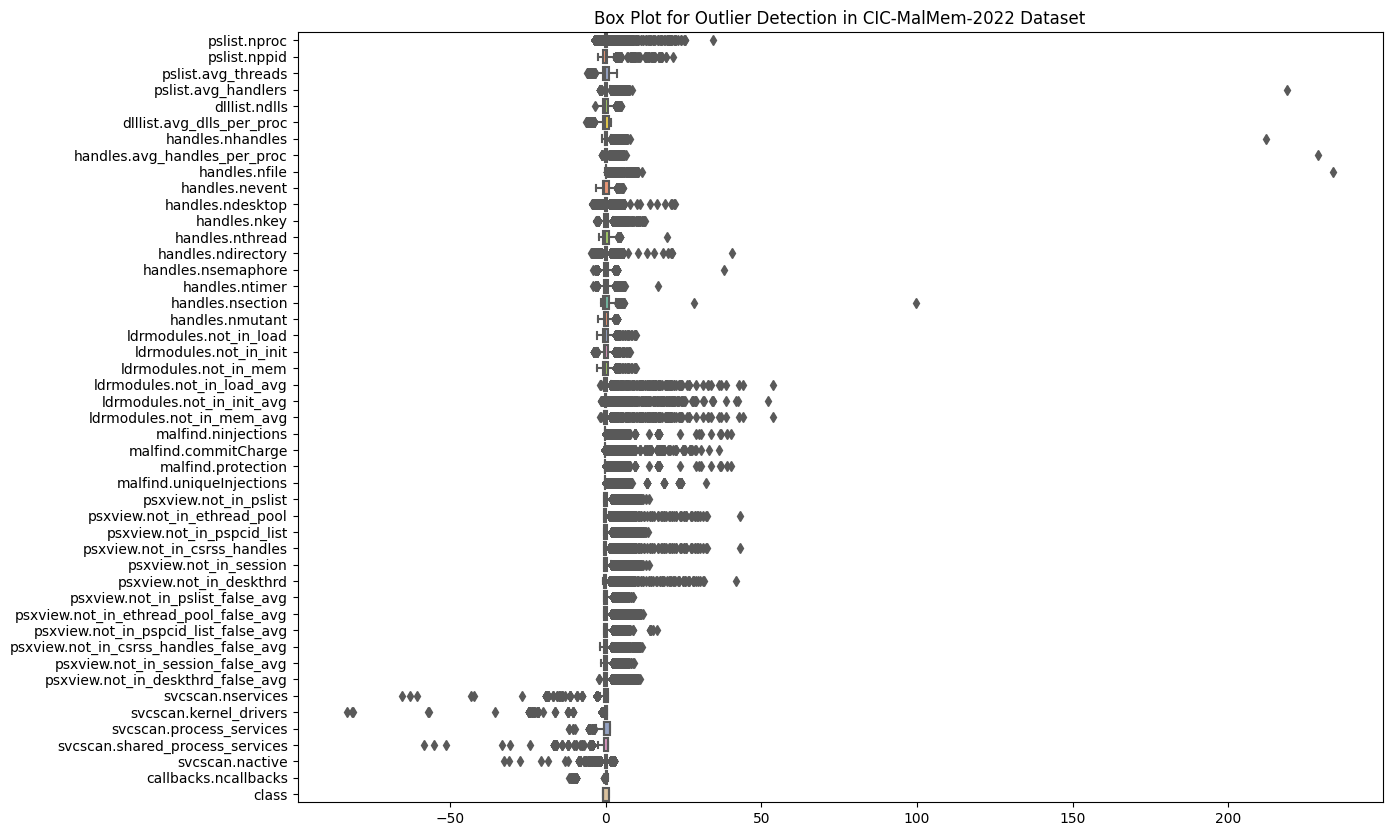

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame
# Drop non-numeric columns if necessary
numeric_df = df_no_outliers.select_dtypes(include=[np.number])

# Create a box plot for each feature
plt.figure(figsize=(14, 10))
sns.boxplot(data=numeric_df, orient='h', palette='Set2')
plt.title('Box Plot for Outlier Detection in CIC-MalMem-2022 Dataset')
plt.show()

<h3>Spliting for Training and Testing</h3>

In [ ]:
# Separate features and labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Class labels
X.shape

(58027, 46)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(58462, 46)

<h3>CNN with 20 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


Mean Accuracy: 99.98%
Mean Training Time (seconds): 7.42
Mean Testing Time (seconds): 0.80
Mean Training Loss: 0.0022
Mean Test Loss: 0.0021


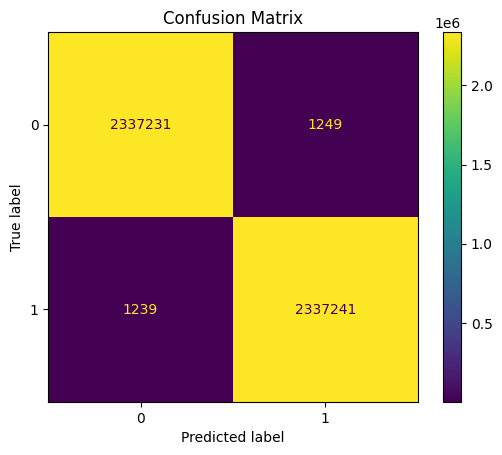

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 46  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/20_ep_accuracy.pdf', format='pdf')
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/20_ep_loss.pdf', format='pdf')
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/20_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 30 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 30/30 [03:31<00:00,  7.05s/it]


Mean Accuracy: 100.00%
Mean Training Time (seconds): 7.10
Mean Testing Time (seconds): 0.75
Mean Training Loss: 0.0016
Mean Test Loss: 0.0015


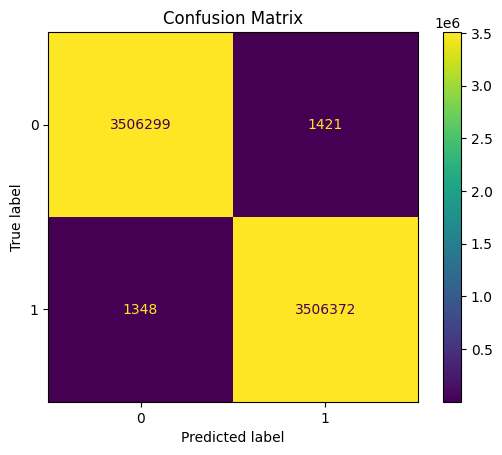

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 46  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/30_ep_accuracy.pdf', format='pdf')
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/30_ep_loss.pdf', format='pdf')
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/30_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 50 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 50/50 [06:05<00:00,  7.31s/it]


Mean Accuracy: 99.98%
Mean Training Time (seconds): 7.11
Mean Testing Time (seconds): 0.76
Mean Training Loss: 0.0010
Mean Test Loss: 0.0008


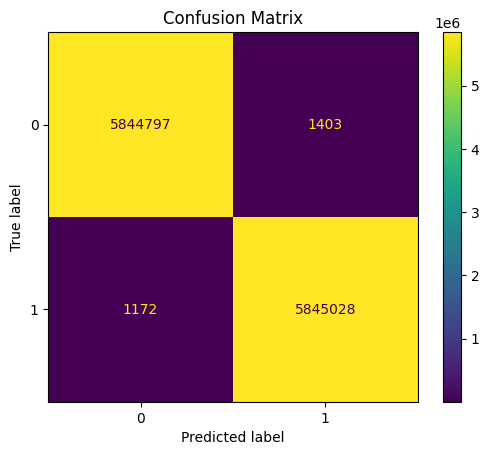

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 46  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 50
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/50_ep_accuracy.pdf', format='pdf')
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/50_ep_loss.pdf', format='pdf')
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/50_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 100 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 100/100 [11:34<00:00,  6.94s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 7.20
Mean Testing Time (seconds): 0.76
Mean Training Loss: 0.0006
Mean Test Loss: 0.0006


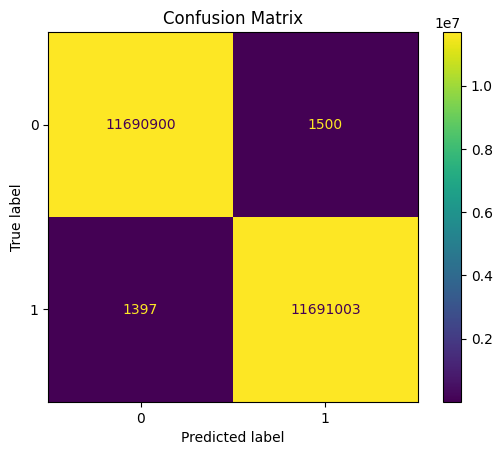

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 46  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/100_ep_accuracy.pdf', format='pdf')
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/100_ep_loss.pdf', format='pdf')
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/100_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN with 150 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 150/150 [17:18<00:00,  6.92s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 6.94
Mean Testing Time (seconds): 0.73
Mean Training Loss: 0.0004
Mean Test Loss: 0.0008


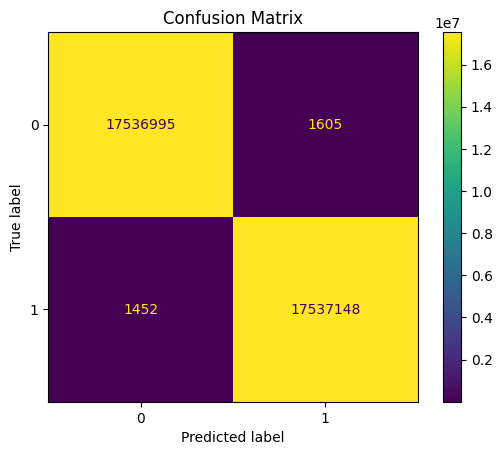

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
train_times = []
test_times = []

all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define a CNN model
    class CNNModel(nn.Module):
        def __init__(self, input_size, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
            self.relu = nn.ReLU()
            self.maxpool = nn.MaxPool1d(kernel_size=2)
            self.fc = nn.Linear(32 * (input_size // 2), num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add a channel dimension (batch_size, 1, input_size)
            x = self.conv1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            x = x.view(x.size(0), -1)  # Flatten
            x = self.fc(x)
            return x

    # Specify the model hyperparameters
    input_size = 46  # Number of input features
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the CNN model
    model = CNNModel(input_size, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 150
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Append true labels and predicted labels for this batch
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        # Measure the time taken for testing
        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

# Calculate and print the mean training and testing times across all folds
mean_train_time = np.mean(train_times)
mean_test_time = np.mean(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/150_ep_accuracy.pdf', format='pdf')
plt.close()  # Close the figure to start a new one

# Plot training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # Change the subplot index to 2
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/150_ep_loss.pdf', format='pdf')
plt.close()  # Close the figure

# Plot the confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)

disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/MalMem/Detection/graphs/cnn/150_ep_confusion.pdf', format='pdf')
plt.show()
plt.close()